In [1]:
import pandas as pd
import numpy as np
import datasets
from datasets import Dataset, load_dataset

In [2]:
dataset = load_dataset('csv', data_files={'train':['hansen_h_bert_ds1.csv', 'hansen_h_bert_ds2.csv',
                                                   'hansen_h_bert_ds3.csv', 'hansen_h_bert_ds4.csv'],
                                          'validation':'hansen_h_bert_ds5.csv',
                                          'test': 'hansen_h_bert_ds6.csv'}, delimiter=',', column_names =['smiles', 'label'])

Using custom data configuration default-7d3a2f2466763cf8


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/pj11/.cache/huggingface/datasets/csv/default-7d3a2f2466763cf8/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dataset['validation'][1]

{'smiles': 'CC\\C(C)=N\\O', 'label': 7.8}

In [4]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

def tokenize_function(examples):
    return tokenizer(examples["smiles"], padding="max_length", truncation=True)

In [5]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [6]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 789
    })
    validation: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 197
    })
    test: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 197
    })
})

In [7]:
#small_train_dataset = tokenized_datasets["train"].shuffle(seed=random_state).select(range(1000))
#small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=random_state).select(range(1000))

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["validation"]
small_test_dataset = tokenized_datasets["test"]

In [8]:
# for regression, num_labels=1
model = AutoModelForSequenceClassification.from_pretrained("seyonec/ChemBERTa-zinc-base-v1", num_labels=1)

Some weights of the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and a

In [9]:
import evaluate
import numpy as np

In [10]:
mae_metric = evaluate.load("mae")
mse_metric = evaluate.load("mse")
pearsonr_metric = evaluate.load("pearsonr")

def compute_metrics(eval_pred):
    # print(eval_pred)
    #logits, labels = eval_pred
    #predictions = np.argmax(logits, axis=-1)
    predictions, labels = eval_pred
    
    metrics = {}
    metrics.update({'mae': mae_metric.compute(predictions=predictions, references=labels)})
    metrics.update({'rmse': mse_metric.compute(predictions=predictions, references=labels, squared=False)})
    metrics.update({'pearsonr': pearsonr_metric.compute(predictions=predictions, references=labels)})
    
    return metrics

In [11]:
para_output_dir = 'C:/Users/pj11/Documents/bert_finetune/hansen_h_cross_val_fold1/'
model_output_path = f'{para_output_dir}/model'

training_args = TrainingArguments(output_dir=para_output_dir, 
                                  evaluation_strategy="epoch",
                                  #per_device_train_batch_size = 64,
                                  #per_device_eval_batch_size = 64,
                                  num_train_epochs=50)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

In [13]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 789
  Num Epochs = 50
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1250
  Number of trainable parameters = 44104705
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Wa

Epoch,Training Loss,Validation Loss,Mae,Rmse,Pearsonr
1,No log,25.510918,{'mae': 3.9472666210329472},{'mse': 5.037851100457441},{'pearsonr': 0.3321296859907823}
2,No log,20.166626,{'mae': 3.2526835590449688},{'mse': 4.481804800571155},{'pearsonr': 0.5542735621971777}
3,No log,18.153715,{'mae': 3.192760278730828},{'mse': 4.257327237509609},{'pearsonr': 0.6060300998309368}
4,No log,14.016592,{'mae': 2.579914667279587},{'mse': 3.741534234073636},{'pearsonr': 0.7297891627543767}
5,No log,13.140087,{'mae': 2.4162114671795503},{'mse': 3.621642983912274},{'pearsonr': 0.7423826961641686}
6,No log,11.939969,{'mae': 2.2998145181818055},{'mse': 3.4531679681969853},{'pearsonr': 0.7540977177922952}
7,No log,11.057774,{'mae': 2.247762613981811},{'mse': 3.3275572853969093},{'pearsonr': 0.7721579370105507}
8,No log,12.780910,{'mae': 2.539199041533591},{'mse': 3.575890661621068},{'pearsonr': 0.7383389569448413}
9,No log,11.703259,{'mae': 2.3320353249664687},{'mse': 3.422922233562919},{'pearsonr': 0.7607411751353427}
10,No log,12.312476,{'mae': 2.2933387317633267},{'mse': 3.5173226192922695},{'pearsonr': 0.7472528247537669}


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors

***** Running Evaluation *****
  Num examples = 197
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: Use

Model weights saved in C:/Users/pj11/Documents/bert_finetune/hansen_h_cross_val_fold1/checkpoint-1000\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was

  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1250, training_loss=5.578670458984375, metrics={'train_runtime': 511.5607, 'train_samples_per_second': 77.117, 'train_steps_per_second': 2.444, 'total_flos': 5225745681561600.0, 'train_loss': 5.578670458984375, 'epoch': 50.0})

In [14]:
#take care of distributed/paralelle training 
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model 
model_to_save.save_pretrained(model_output_path)

Configuration saved in C:/Users/pj11/Documents/bert_finetune/hansen_h_cross_val_fold1//model\config.json
Model weights saved in C:/Users/pj11/Documents/bert_finetune/hansen_h_cross_val_fold1//model\pytorch_model.bin


In [15]:
# making prediction 
model = AutoModelForSequenceClassification.from_pretrained(model_output_path)

# arguments for Trainer
test_args = TrainingArguments(
     output_dir =model_output_path,
     do_train = False,
     do_predict = True,
     dataloader_drop_last = False
)

# Init Trainer
trainer=Trainer(
          model = model,
          args = test_args,
          compute_metrics = compute_metrics)

test_results = trainer.predict(small_test_dataset)

loading configuration file C:/Users/pj11/Documents/bert_finetune/hansen_h_cross_val_fold1//model\config.json
Model config RobertaConfig {
  "_name_or_path": "C:/Users/pj11/Documents/bert_finetune/hansen_h_cross_val_fold1//model",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "regression",
  "torch_dtype": "float32",
  "transformers_version": "4.26.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size

In [16]:
test_results[1]

array([10.9,  1. ,  3.2,  0. ,  5.5,  8.5, 17.6,  4.3,  4. ,  8. ,  1.4,
        9.2,  6.2,  4.1,  6.2,  7.5,  5.2, 10.7, 10. ,  8.4,  4. ,  8.2,
       16. ,  4.9, 21. , 11.8, 10.6,  5.4,  3.8,  3.6,  3.1,  5.7,  9.6,
        0. ,  4.6,  4.8, 12. ,  7.3,  7.5, 13. ,  6. ,  5.2,  5.9, 10.8,
        8.2, 10.3, 14.6, 11.3, 14.5, 11. ,  5.6, 13. ,  7. ,  6.4,  7.6,
        3.8,  0. ,  2.9,  0. ,  5.9, 10.2,  4.1,  3.7,  2.4,  4.1, 14.2,
        0. ,  7.8,  8.6, 13. , 20.2,  5. , 12. , 11.7,  0. ,  6.5,  5.7,
       19.5, 14. , 12.9,  5.9,  1.8,  6.2,  5.8, 10.9,  5.7,  4.5,  9. ,
        7.5,  6.7,  4. , 13.4, 13.3, 17.7, 10.5,  5.7,  7.5, 13.8, 14.6,
       19. , 14. ,  6.7,  3.9,  7. ,  5.1,  2. ,  4.1,  5.6, 14.3,  8.8,
       14.9, 12.3,  2.2,  1. ,  5.9, 10.8,  3.1,  4.5,  5.3,  2. ,  9. ,
       18.8,  2.3,  8. ,  5.7,  0. ,  5.9,  6.6,  0. ,  3.8,  5.3,  2. ,
        1.1,  1.7,  0.6,  7.8,  7. , 21.1, 11.9, 10.7, 12.8,  0. ,  1.8,
        8. ,  0.2,  7.5,  4.1,  5.6,  8.4,  5.3, 11

In [17]:
test_results[2]

{'test_loss': 8.151893615722656,
 'test_mae': {'mae': 1.7779674674880686},
 'test_rmse': {'mse': 2.8557219026969594},
 'test_pearsonr': {'pearsonr': 0.827209818848175},
 'test_runtime': 1.6493,
 'test_samples_per_second': 119.447,
 'test_steps_per_second': 4.244}

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import math

# MAE, AE and RMSE give an idea of the error distribution
print(mean_absolute_error(test_results[0], test_results[1]))

#RMSEs
print(math.sqrt(mean_squared_error(test_results[0], test_results[1])))

# R^2 Coefficient of Determination
print(r2_score(test_results[0], test_results[1]))

1.7779675
2.855721729933769
0.5864926067278177


Text(0, 0.5, 'pred. Hansen h')

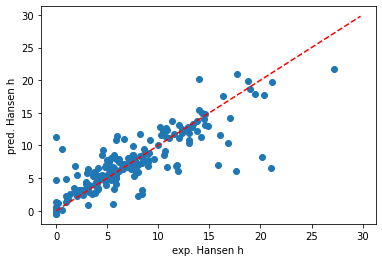

In [46]:
import matplotlib.pyplot as plt
plt.figure(1)

ln = np.arange(0, 30, 0.2)
plt.plot(ln, ln,'r--')
plt.scatter(test_results[1], test_results[0])
plt.xlabel('exp. Hansen h')
plt.ylabel('pred. Hansen h')

In [21]:
pd_pred_test=pd.DataFrame(test_results[0], columns=["predict"])
pd_exp_test=pd.DataFrame(test_results[1], columns=["exp"])
pd_smiles=pd.DataFrame(dataset['test']['smiles'], columns=["smiles"])
pd_test=pd.concat((pd_smiles, pd_exp_test, pd_pred_test), axis=1)

# save predicton to csv 
pd_test.to_csv('hansen_h_bert_ds6_fold1_results.csv')

In [22]:
pd_test

,smiles,exp,predict
0,SC#N,10.9,6.721265
1,CC1CCCC1,1.0,2.252125
2,CCCCC(CC)CNCC(CC)CCCC,3.2,3.982227
3,CCCCCCCCCC,0.0,0.439862
4,O=C(CCCCCCCCC(=O)OCc1ccccc1)OCc2ccccc2,5.5,5.696132
...,...,...,...
192,CC=CCC#N,5.1,5.690761
193,CCCCOC(C)=O,6.3,6.363953
194,CC(C)=C=O,4.8,6.658949
195,Fc1cccc(F)c1C#N,3.2,2.822671
